In [1]:
# 挂载硬盘
import os
from google.colab import drive

drive.mount('/content/drive')
# 重复执行的话会出一个提醒已经挂载的warn不过不影响

path = "/content/drive/My Drive/Colab Notebooks"

os.chdir(path)
os.listdir(path)

!ls

 datasets  'EfficientNetV2 Saliency Map.ipynb'	'“欢迎使用 Colaboratory”的副本'


In [2]:
import torch
import timm
import torchvision.transforms as T
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image
import json

# 获取 ImageNet 类别标签
response = requests.get('https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json')
labels = json.loads(response.text)

# 初始化预训练模型
model = timm.create_model('tf_efficientnetv2_l', pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [3]:
# 图像预处理
def preprocess(image, size=300):
    transform = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

In [4]:
# 转换为概率分布
def output_to_probabilities(output):
    probabilities = torch.nn.Softmax(dim=1)(output)
    return probabilities.squeeze().detach().cpu().numpy()

In [5]:
def grad_cam(model, input_tensor, target_layer, target_class):
    # 设置模型为评估模式，以便在执行推理时关闭Dropout等操作
    model.eval()

    # 定义梯度的hook函数
    gradients = None
    def hook_function(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_in[0]

    # 注册hook函数到目标层
    target_layer.register_backward_hook(hook_function)

    # 前向传递，获取输出
    output = model(input_tensor)

    # 清空所有参数的梯度
    model.zero_grad()

    # 获取目标类别的得分
    target_score = output[0, target_class]

    # 反向传递，计算梯度
    target_score.backward()

    # 获取梯度
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # 获取目标层的激活
    activations = model.forward_features(input_tensor).detach()

    # 根据梯度加权激活
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # 在空间维度上取平均值，得到加权激活的热力图
    heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()

    # 对热力图进行ReLU操作
    heatmap = np.maximum(heatmap, 0)

    # 对热力图进行归一化
    heatmap /= np.max(heatmap)

    return heatmap


def overlay_heatmap(image, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET): 
    # 将热力图缩放到与原始图像相同的大小
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # 将热力图转换为伪彩色图像
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)

    # 将热力图与原始图像按照指定的透明度进行叠加
    superimposed_img = heatmap * alpha + image * (1 - alpha)

    # 将叠加后的图像转换为uint8类型并返回
    return np.uint8(superimposed_img)

In [6]:
# 图像路径模板
image_path_template = 'datasets/images/{}.png'

# 读取和处理所有 25 张图像
images = [Image.open(image_path_template.format(i)) for i in range(25)]

# 输出 EfficientV2 预测结果
print("EfficientV2 Predictions:")
for i, img in enumerate(images):
    # 预处理图像
    input_tensor = preprocess(img, size=300)
    input_tensor.requires_grad_()

    # 计算概率分布
    model.eval()
    scores = model(input_tensor)
    probabilities = output_to_probabilities(scores)

    # 获取前 5 个最可能的类别及其概率
    top5_probs, top5_indices = torch.topk(torch.tensor(probabilities), 5)
    top5_probs = top5_probs.numpy()
    top5_classes = [labels[index] for index in top5_indices.numpy()]
    
    # 输出前 5 个最可能的类别及其概率
    print(f"Image {i} top 5 predicted classes:")
    for prob, label in zip(top5_probs, top5_classes):
        print(f"  {label}: {prob*100:.2f}%")

Image 0 top 5 predicted classes:
  hay: 38.95%
  barn: 0.30%
  website: 0.25%
  nematode: 0.24%
  parachute: 0.23%
Image 1 top 5 predicted classes:
  quail: 48.05%
  website: 1.78%
  television: 0.61%
  window shade: 0.56%
  entertainment center: 0.52%
Image 2 top 5 predicted classes:
  Tibetan Mastiff: 64.39%
  Tibetan Terrier: 2.53%
  Newfoundland: 0.25%
  Leonberger: 0.20%
  Chow Chow: 0.18%
Image 3 top 5 predicted classes:
  Border Terrier: 71.76%
  Norfolk Terrier: 2.03%
  Norwich Terrier: 0.50%
  Cairn Terrier: 0.19%
  Griffon Bruxellois: 0.19%
Image 4 top 5 predicted classes:
  brown bear: 61.20%
  polar bear: 10.40%
  American black bear: 0.56%
  sloth bear: 0.36%
  otter: 0.14%
Image 5 top 5 predicted classes:
  soap dispenser: 81.83%
  sink: 0.36%
  paper towel: 0.33%
  lotion: 0.28%
  switch: 0.17%
Image 6 top 5 predicted classes:
  pajamas: 52.96%
  couch: 8.85%
  quilt: 3.73%
  kimono: 1.86%
  window shade: 1.21%
Image 7 top 5 predicted classes:
  gorilla: 81.61%
  chimpan

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


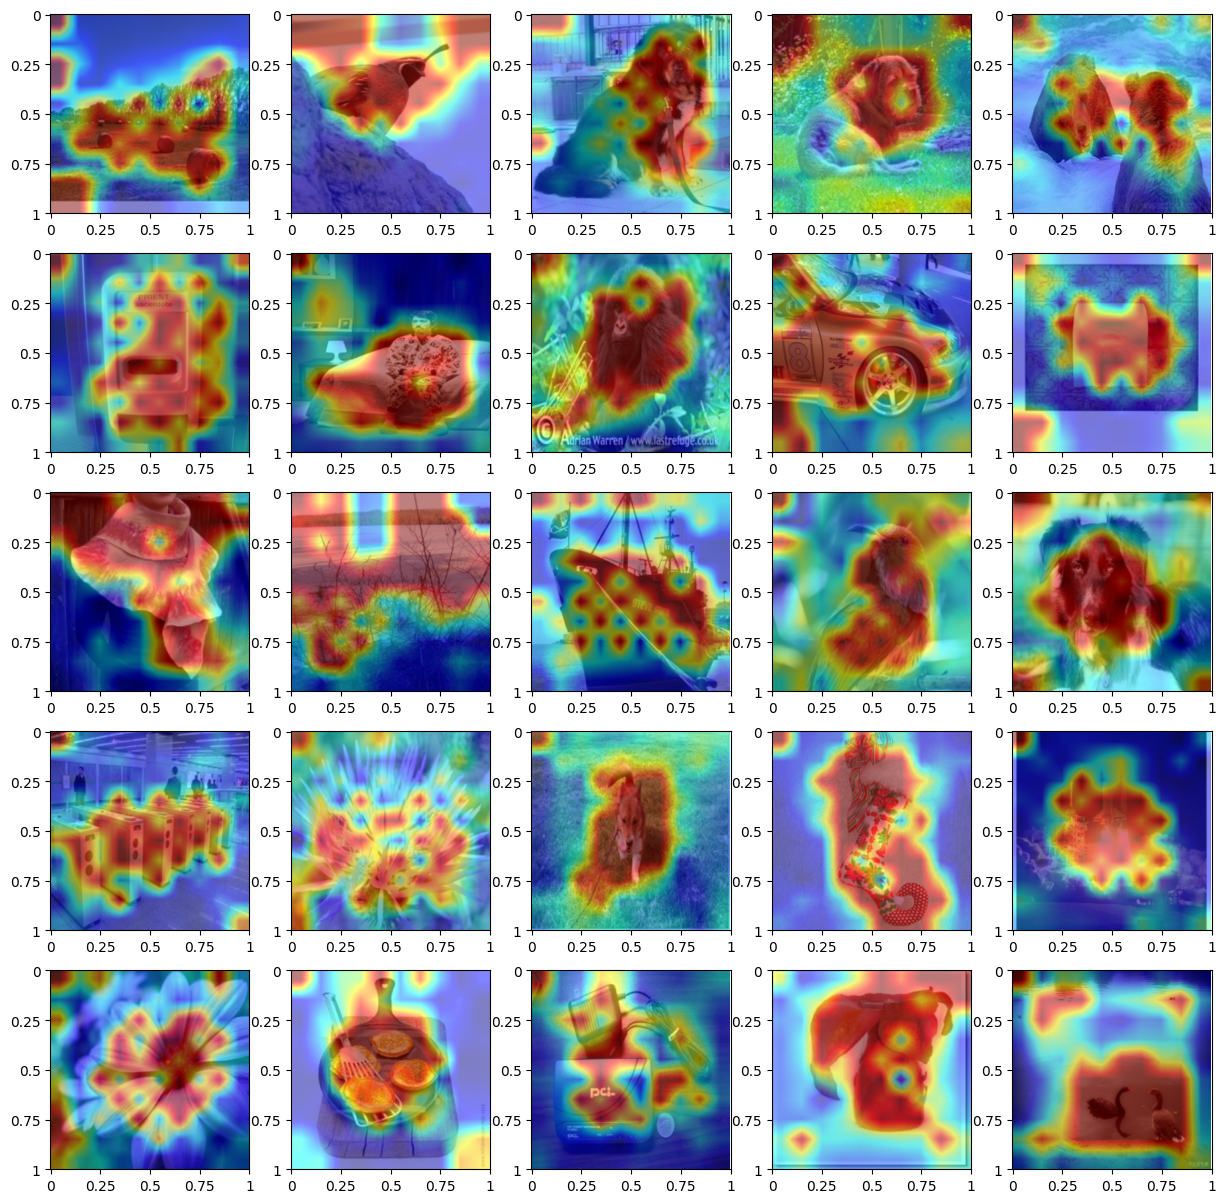

In [7]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i, img in enumerate(images):
    # 预处理图像
    input_tensor = preprocess(img, size=300)
    input_tensor.requires_grad_()

    # 获取目标类
    model.eval()
    scores = model(input_tensor)
    target_class = scores.argmax(dim=1).item()

    # 获取目标层
    target_layer = model.blocks[-1][-1].conv_pwl

    # 生成 Grad-CAM 热图
    heatmap = grad_cam(model, input_tensor, target_layer, target_class)

    # 准备原始图像和热图以进行叠加
    original_image = np.array(img.resize((300, 300)))
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # 在原始图像上叠加热图
    superimposed_image = overlay_heatmap(original_image, heatmap)

    # 计算子图的行和列索引
    row = i // 5
    col = i % 5

    # 在子图上显示叠加后的图像
    axes[row, col].imshow(superimposed_image)
    # axes[row, col].axis('off')

    # 设置坐标轴刻度
    axes[row, col].set_xticks([0, 0.25 * 300, 0.5 * 300, 0.75 * 300, 300])
    axes[row, col].set_yticks([0, 0.25 * 300, 0.5 * 300, 0.75 * 300, 300])
    
    # 设置坐标轴标签
    axes[row, col].set_xticklabels([0, 0.25, 0.5, 0.75, 1])
    axes[row, col].set_yticklabels([0, 0.25, 0.5, 0.75, 1])

plt.show()